# Stable Baselines, a Fork of OpenAI Baselines - Monitor Training and Plotting

Github Repo: [https://github.com/hill-a/stable-baselines](https://github.com/hill-a/stable-baselines)

Medium article: [https://medium.com/@araffin/stable-baselines-a-fork-of-openai-baselines-df87c4b2fc82](https://medium.com/@araffin/stable-baselines-a-fork-of-openai-baselines-df87c4b2fc82)

[RL Baselines Zoo](https://github.com/araffin/rl-baselines-zoo) is a collection of pre-trained Reinforcement Learning agents using Stable-Baselines.

It also provides basic scripts for training, evaluating agents, tuning hyperparameters and recording videos.

Documentation is available online: [https://stable-baselines.readthedocs.io/](https://stable-baselines.readthedocs.io/)

## Install Dependencies and Stable Baselines Using Pip

List of full dependencies can be found in the [README](https://github.com/hill-a/stable-baselines).

```
sudo apt-get update && sudo apt-get install cmake libopenmpi-dev zlib1g-dev
```


```
pip install stable-baselines[mpi]
```

In [ ]:
# !apt install swig cmake libopenmpi-dev zlib1g-dev
# !pip install stable-baselines[mpi]==2.8.0 box2d box2d-kengz
# Stable Baselines only supports tensorflow 1.x for now
# %tensorflow_version 1.x

In [1]:
%load_ext autoreload
%autoreload 2
try:
    %%tensorflow_version 1.x
except:
    pass

import os
import sys
lib_path = os.path.abspath('../..')
if lib_path not in sys.path:
    print('inserting the following to path',lib_path)
    sys.path.insert(0,lib_path)
print(sys.path)
#-----------------------------------
# Filter tensorflow version warnings
#-----------------------------------
# https://stackoverflow.com/questions/40426502/is-there-a-way-to-suppress-the-messages-tensorflow-prints/40426709
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import warnings
# https://stackoverflow.com/questions/15777951/how-to-suppress-pandas-future-warning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
import tensorflow as tf
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)
import logging
tf.get_logger().setLevel(logging.ERROR)

# from IPython.core.debugger import set_trace     # GK debug

['/home/guy/workspace/study/remote/stable-baselines/my_colabs/stbl_team', '/home/guy/workspace/study/remote/stable-baselines/my_colabs/stbl_team', '/home/guy/workspace/study/remote/agents', '/home/guy/workspace/study/remote/stable-baselines', '/home/guy/anaconda3/envs/rl15/lib/python37.zip', '/home/guy/anaconda3/envs/rl15/lib/python3.7', '/home/guy/anaconda3/envs/rl15/lib/python3.7/lib-dynload', '', '/home/guy/anaconda3/envs/rl15/lib/python3.7/site-packages', '/home/guy/anaconda3/envs/rl15/lib/python3.7/site-packages/IPython/extensions', '/home/guy/.ipython']


1000 timesteps
Best mean reward: -inf - Last mean reward per episode: -491.23
Saving new best model
1917 timesteps
Best mean reward: -491.23 - Last mean reward per episode: -553.77
2936 timesteps
Best mean reward: -491.23 - Last mean reward per episode: -637.21
3928 timesteps
Best mean reward: -491.23 - Last mean reward per episode: -638.57
4958 timesteps
Best mean reward: -491.23 - Last mean reward per episode: -630.34
5994 timesteps
Best mean reward: -491.23 - Last mean reward per episode: -616.38
6688 timesteps
Best mean reward: -491.23 - Last mean reward per episode: -608.34
7883 timesteps
Best mean reward: -491.23 - Last mean reward per episode: -604.78
8766 timesteps
Best mean reward: -491.23 - Last mean reward per episode: -599.41
9907 timesteps
Best mean reward: -491.23 - Last mean reward per episode: -592.25
10848 timesteps
Best mean reward: -491.23 - Last mean reward per episode: -609.11
11692 timesteps
Best mean reward: -491.23 - Last mean reward per episode: -604.55
12789 t

94452 timesteps
Best mean reward: -156.23 - Last mean reward per episode: -195.62
95452 timesteps
Best mean reward: -156.23 - Last mean reward per episode: -192.19
96452 timesteps
Best mean reward: -156.23 - Last mean reward per episode: -191.14
97452 timesteps
Best mean reward: -156.23 - Last mean reward per episode: -189.25
98706 timesteps
Best mean reward: -156.23 - Last mean reward per episode: -186.75
99706 timesteps
Best mean reward: -156.23 - Last mean reward per episode: -185.57


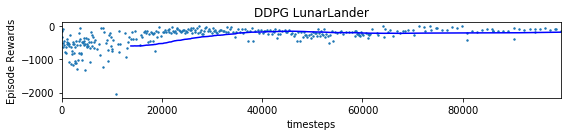

In [2]:
# import os

import gym
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines.ddpg.policies import LnMlpPolicy
from stable_baselines.bench import Monitor
from stable_baselines.results_plotter import load_results, ts2xy
from stable_baselines.ddpg.ddpg import DDPG
from stable_baselines.ddpg.noise import AdaptiveParamNoiseSpec
from stable_baselines import results_plotter


best_mean_reward, n_steps = -np.inf, 0

def callback(_locals, _globals):
    """
    Callback called at each step (for DQN an others) or after n steps (see ACER or PPO2)
    :param _locals: (dict)
    :param _globals: (dict)
    """
    global n_steps, best_mean_reward
    # Print stats every 1000 calls
    if (n_steps + 1) % 1000 == 0:
        # Evaluate policy training performance
        x, y = ts2xy(load_results(log_dir), 'timesteps')
        if len(x) > 0:
            mean_reward = np.mean(y[-100:])
            print(x[-1], 'timesteps')
            print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(best_mean_reward, mean_reward))

            # New best model, you could save the agent here
            if mean_reward > best_mean_reward:
                best_mean_reward = mean_reward
                # Example for saving best model
                print("Saving new best model")
                _locals['self'].save(log_dir + 'best_model.pkl')
    n_steps += 1
    return True

# Create log dir
log_dir = "tmp/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = gym.make('LunarLanderContinuous-v2')
env = Monitor(env, log_dir, allow_early_resets=True)

# Add some param noise for exploration
param_noise = AdaptiveParamNoiseSpec(initial_stddev=0.1, desired_action_stddev=0.1)
# Because we use parameter noise, we should use a MlpPolicy with layer normalization
model = DDPG(LnMlpPolicy, env, param_noise=param_noise, verbose=0)
# Train the agent
time_steps = 1e5
model.learn(total_timesteps=int(time_steps), callback=callback)

results_plotter.plot_results([log_dir], time_steps, results_plotter.X_TIMESTEPS, "DDPG LunarLander")
plt.show()

## Import policy, RL agent, Wrappers

In [2]:
import os

import gym
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines.ddpg.policies import LnMlpPolicy
from stable_baselines.bench import Monitor
from stable_baselines.results_plotter import load_results, ts2xy
from stable_baselines.ddpg import DDPG 
from stable_baselines.td3 import TD3
from stable_baselines.common.noise import AdaptiveParamNoiseSpec, NormalActionNoise

## Define a Callback Function


In [3]:
best_mean_reward, n_steps = -np.inf, 0

def callback(_locals, _globals):
    """
    Callback called at each step (for DQN an others) or after n steps (see ACER or PPO2)
    :param _locals: (dict)
    :param _globals: (dict)
    """
    global n_steps, best_mean_reward
    # Print stats every 1000 calls
    if (n_steps + 1) % 1000 == 0:
        # Evaluate policy training performance
        x, y = ts2xy(load_results(log_dir), 'timesteps')
        if len(x) > 0:
            mean_reward = np.mean(y[-100:])
            print(x[-1], 'timesteps')
            print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(best_mean_reward, mean_reward))

            # New best model, you could save the agent here
            if mean_reward > best_mean_reward:
                best_mean_reward = mean_reward
                # Example for saving best model
                print("Saving new best model")
                _locals['self'].save(log_dir + 'best_model.pkl')
    n_steps += 1
    # Returning False will stop training early
    return True

## Create and wrap the environment

We will be using Lunar Lander environment with continuous actions

In [ ]:
# Create log dir
log_dir = "/tmp/ddpg"
os.makedirs(log_dir, exist_ok=True)
# Create and wrap the environment
env = gym.make('LunarLanderContinuous-v2')
# Logs will be saved in log_dir/monitor.csv
env = Monitor(env, log_dir, allow_early_resets=True)

## Define and train the DDPG agent

In [ ]:
# Add some param noise for exploration
param_noise = AdaptiveParamNoiseSpec(initial_stddev=0.1, desired_action_stddev=0.1)
# Because we use parameter noise, we should use a MlpPolicy with layer normalization
model = DDPG(LnMlpPolicy, env, param_noise=param_noise, verbose=0)
# Train the agent
model.learn(total_timesteps=int(1e5), callback=callback)

## Plotting helpers

Stable Baselines has some built-in plotting helper, that you can find in `stable_baselines.results_plotter`. However, to show how to do it yourself, we are going to use custom plotting functions. 

In [4]:
log_dir = "tmp/"

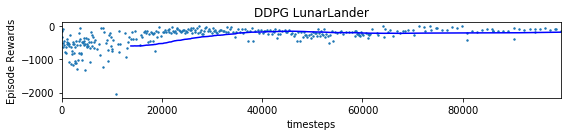

In [5]:
from stable_baselines import results_plotter

# Helper from the library
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "DDPG LunarLander")

In [6]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()


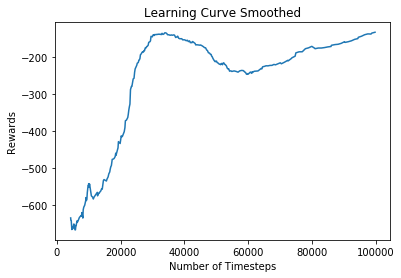

In [7]:
plot_results(log_dir)

## TD3 vs DDPG

TD3 is the successor of DDPG (cf [Documentation](https://stable-baselines.readthedocs.io/))  


As you can read from the [TD3 documentation](https://stable-baselines.readthedocs.io/en/master/modules/td3.html) :  
*The TD3 model does not support stable_baselines.common.policies because it uses double q-values estimation, as a result it must use its own policy models (see [TD3 Policies](https://stable-baselines.readthedocs.io/en/master/modules/td3.html#td3-policies)).*

as a result, the following comment from [custom policy](https://stable-baselines.readthedocs.io/en/master/guide/custom_policy.html) is not relevant here :  
*Deprecated since version 2.3.0: Use `net_arch` instead of `layers` parameter to define the network architecture. It allows to have a greater control.*  

if we look at `td3.policies.FeedForwardPolic` we see that it still accepts `layers` as the key for `policy_kwargs`.

In [8]:
# Create log dir
log_dir = "./tmp/td3/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = gym.make('LunarLanderContinuous-v2')
# Logs will be saved in log_dir/monitor.csv
env = Monitor(env, log_dir, allow_early_resets=True)

In [9]:
# Create action noise because TD3 and DDPG use a deterministic policy
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

In [10]:
# net_kwargs = dict(layers=[400, 300])
# model_td3 = TD3("MlpPolicy", env, action_noise=action_noise, verbose=0)
# see comment above 
policy_kwargs = dict(layers=[400, 300])
model_td3 = TD3("MlpPolicy", env, action_noise=action_noise, policy_kwargs=policy_kwargs, verbose=0)

In [11]:
# Avoid the need of global variables
model_td3.best_mean_reward, model_td3.n_steps = -np.inf, 0

def callback(_locals, _globals):
    """
    Callback called at each step (for DQN an others) or after n steps (see ACER or PPO2)
    :param _locals: (dict)
    :param _globals: (dict)
    """
    # Retrieve the self object
    self_ = _locals['self']
    # Print stats every 1000 calls
    if (self_.n_steps + 1) % 1000 == 0:
        # Evaluate policy training performance
        x, y = ts2xy(load_results(log_dir), 'timesteps')
        if len(x) > 0:
            mean_reward = np.mean(y[-100:])
            print(x[-1], 'timesteps')
            print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(self_.best_mean_reward, mean_reward))

            # New best model, you could save the agent here
            if mean_reward > self_.best_mean_reward:
                self_.best_mean_reward = mean_reward
                # Example for saving best model
                print("Saving new best model")
                self_.save(log_dir + 'best_model.pkl')
    self_.n_steps += 1
    # Returning False will stop training early
    return True

In [12]:
# Train the agent
model_td3.learn(total_timesteps=int(1e5), callback=callback)

996 timesteps
Best mean reward: -inf - Last mean reward per episode: -359.97
Saving new best model
1861 timesteps
Best mean reward: -359.97 - Last mean reward per episode: -335.70
Saving new best model
2776 timesteps
Best mean reward: -335.70 - Last mean reward per episode: -298.21
Saving new best model
3996 timesteps
Best mean reward: -298.21 - Last mean reward per episode: -284.03
Saving new best model
4996 timesteps
Best mean reward: -284.03 - Last mean reward per episode: -273.73
Saving new best model
5943 timesteps
Best mean reward: -273.73 - Last mean reward per episode: -257.67
Saving new best model
6637 timesteps
Best mean reward: -257.67 - Last mean reward per episode: -255.65
Saving new best model
7817 timesteps
Best mean reward: -255.65 - Last mean reward per episode: -249.05
Saving new best model
8973 timesteps
Best mean reward: -249.05 - Last mean reward per episode: -239.26
Saving new best model
9944 timesteps
Best mean reward: -239.26 - Last mean reward per episode: -238

87423 timesteps
Best mean reward: -100.19 - Last mean reward per episode: -96.43
Saving new best model
88423 timesteps
Best mean reward: -96.43 - Last mean reward per episode: -93.93
Saving new best model
89423 timesteps
Best mean reward: -93.93 - Last mean reward per episode: -94.48
90423 timesteps
Best mean reward: -93.93 - Last mean reward per episode: -94.25
91423 timesteps
Best mean reward: -93.93 - Last mean reward per episode: -94.59
92423 timesteps
Best mean reward: -93.93 - Last mean reward per episode: -95.93
93423 timesteps
Best mean reward: -93.93 - Last mean reward per episode: -96.75
94423 timesteps
Best mean reward: -93.93 - Last mean reward per episode: -96.46
95423 timesteps
Best mean reward: -93.93 - Last mean reward per episode: -96.95
96423 timesteps
Best mean reward: -93.93 - Last mean reward per episode: -97.85
97423 timesteps
Best mean reward: -93.93 - Last mean reward per episode: -100.46
98423 timesteps
Best mean reward: -93.93 - Last mean reward per episode: -

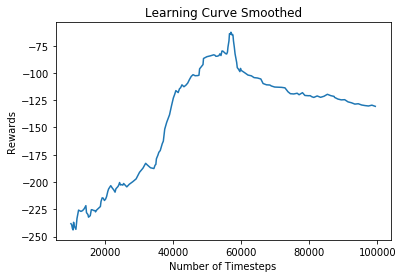

In [13]:
plot_results(log_dir)

In [15]:
log_dir

'tmp/'